# Experiment 1: MNIST

An attempt at putting the Fast.AI library to the test on the MNIST dataset and Kaggle competition.

## Downloading data.

Going to attempt to download the MNIST data using the Kaggle API. I've added my API token to the Kaggle config as follows:

```
$ mkdir ~/.kaggle
$ vi ~/.kaggle/kaggle.json
$ chmod 600 ~/.kaggle/kaggle.json
```

Then installed the Kaggle library as follows:

```
pip install kaggle
```

In [4]:
!kaggle competitions download -c digit-recognizer --path='./data/mnist-kaggle'

train.csv: Downloaded 73MB of 73MB
test.csv: Downloaded 49MB of 49MB
sample_submission.csv: Downloaded 235KB of 235KB


In [5]:
!ls -l ./data/mnist-kaggle/

total 125136
-rw-rw-r-- 1 lex lex   240909 Mar 28 01:21 sample_submission.csv
-rw-rw-r-- 1 lex lex 51118296 Mar 28 01:21 test.csv
-rw-rw-r-- 1 lex lex 76775041 Mar 28 01:21 train.csv


## Loading and exploring the data

In [5]:
import csv
import pprint

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
fh = open('./data/mnist-kaggle/train.csv')
csv_reader = csv.reader(fh)

In [7]:
header = next(csv_reader)

In [8]:
pprint.pprint(header[:10])

['label',
 'pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8']


In [9]:
print(f"Num of columns: {len(header[1:])}")

Num of columns: 784


The docs state that the images are all 24x24 and each pixel is represented by a number 0 to 1, which means the images are greyscale.

Let's explore a single image.

In [10]:
label, *img_data = next(csv_reader)

In [11]:
label

'1'

In [12]:
img_data[-10:]

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

In [13]:
img_arr = np.array([int(i) for i in img_data])

In [14]:
img_arr.shape

(784,)

In [15]:
img_arr = img_arr.reshape((28, 28))

In [16]:
img_arr.shape

(28, 28)

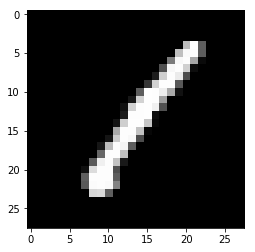

In [17]:
plt.imshow(img_arr, cmap='gray')

In [18]:
def load_img(img_data):
    img_arr = np.array([int(i) for i in img_data])
    img_arr = img_arr.reshape((28, 28))
    return img_arr

Now lets load all images into a `(m, 28, 28)` matrix, when m is the number of images in the training set.

In [19]:
fh.seek(0)
next(csv_reader)[:10]

['label',
 'pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8']

In [20]:
line_count = 0
for line in csv_reader: line_count += 1

In [21]:
m = line_count

In [22]:
all_imgs = np.zeros((m, 28, 28), dtype=np.float32)
all_labels = np.zeros((m,), dtype=np.uint8)

In [23]:
fh.seek(0)
next(csv_reader)[:10]

for i, line in enumerate(csv_reader):
    label, *img_data = line
    all_imgs[i] = load_img(img_data)
    all_labels[i] = int(label)

9


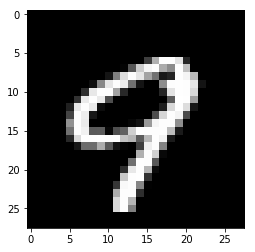

In [24]:
print(all_labels[100])
plt.imshow(all_imgs[100], cmap='gray')

5


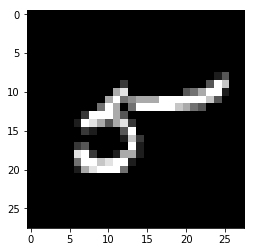

In [25]:
print(all_labels[1001])
plt.imshow(all_imgs[1001], cmap='gray')

8


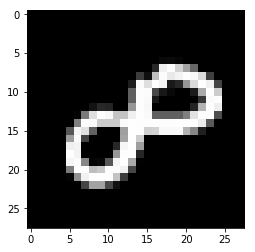

In [26]:
print(all_labels[8888])
plt.imshow(all_imgs[8888], cmap='gray')

### Plot pixel intensity

Create a histogram of pixel intensity for a single image. Will help understand the pixel range and whether the data has been normalised. Took the idea from this notebook: https://www.kaggle.com/paultimothymooney/identify-monkey-species-from-image

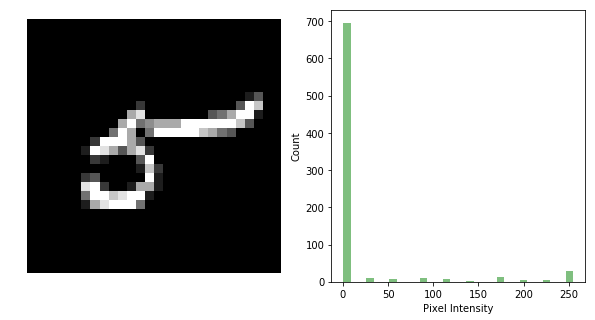

In [27]:
def plot_histogram(img):
    """Plot histogram of pixel intensities."""
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(img[:,:].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);

plot_histogram(all_imgs[1001])


Now save the data to prevent having to reprocess it.

In [167]:
np.save('data/mnist_all_imgs', all_imgs)
np.save('data/mnist_all_labels', all_labels)

## Loading the data from disk

In [265]:
all_imgs = np.load('data/mnist_all_imgs.npy')
all_labels = np.load('data/mnist_all_labels.npy')

## Training/validation split

We'll create a validation set with around 3000 images. Should be more than enough to validate the model's performance.

In [266]:
val_set_size = 3000
m

42000

In [267]:
indices = np.random.permutation(all_imgs.shape[0])
training_idx, val_idx = indices[:-val_set_size], indices[-val_set_size:]

training_set, val_set = all_imgs[training_idx], all_imgs[val_idx]
training_labels, val_labels = all_labels[training_idx], all_labels[val_idx]

In [268]:
print(training_set.shape)
print(training_labels.shape)

(39000, 28, 28)
(39000,)


In [269]:
print(val_set.shape)
print(val_labels.shape)

(3000, 28, 28)
(3000,)


## Training with Fast.AI

In [481]:
from fastai.fastai.torch_imports import resnext101_64

from fastai.fastai.dataset import ImageClassifierData
from fastai.fastai.conv_learner import ConvLearner
from fastai.fastai.transforms import tfms_from_stats, RandomRotate, transforms_basic
from fastai.fastai.plots import plots, plot_confusion_matrix
from fastai.fastai.core import to_np

from torchvision.transforms import Compose, RandomRotation
import pandas as pd

In [271]:
arch = resnext101_64
bs = 64
sz = 28

Since the lesson loads images from path and we have images in a NumPy array, it appears we use `from_arrays`. It appears to require an image with 3 channels, so adding them in as follows:

In [272]:
training_set  = np.stack((training_set,) * 3,axis=-1)
val_set = np.stack((val_set,) * 3,axis = -1)

In [273]:
training_set = training_set / 255
val_set = val_set / 255

In [274]:
training_set = training_set.transpose((0, 3, 1, 2))
val_set = val_set.transpose((0, 3, 1, 2))

In [275]:
print(training_set.shape)
print(val_set.shape)

(39000, 3, 28, 28)
(3000, 3, 28, 28)


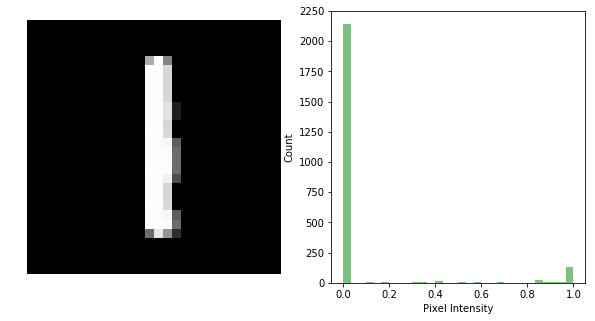

In [279]:
plot_histogram(training_set[1001].transpose((1, 2, 0)))

### Preparing data

Can't seem to get data augmentations to work. The library seems to expect data to be channels last when using augmentation, but then the model doesn't train very well. Leaving them out for now.

In [326]:
# Note that the first argument is the paths for caching stuff.

data = ImageClassifierData.from_arrays(
    './data/mnist-kaggle/',
    trn=(training_set, training_labels.astype(np.int8)),
    val=(val_set, val_labels.astype(np.int8)))

In [327]:
type(data)

fastai.fastai.dataset.ImageClassifierData

In [328]:
data.val_y

array([4, 8, 8, ..., 2, 8, 8], dtype=int8)

### Training model

The MNIST dataset is very different from ImageNet. I've tried using the precomputed weights and leaving layers frozen, but it seems to work best if I unfreeze all layers.

In [329]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.unfreeze()

In [330]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  5%|▍         | 28/610 [00:09<03:24,  2.85it/s, loss=2.81]  


Exception in thread Thread-37:
Traceback (most recent call last):
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 82%|████████▏ | 502/610 [02:56<00:38,  2.84it/s, loss=1.25] 


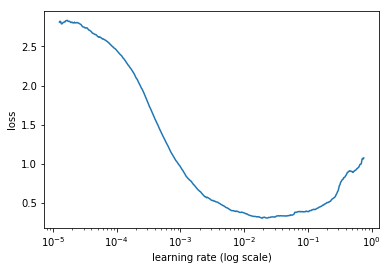

In [331]:
learn.sched.plot()

In [332]:
lr = 0.005

In [333]:
learn.fit(lr, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.104331   0.036777   0.987035  
    1      0.045208   0.039908   0.989362                     
    2      0.038044   0.022603   0.993351                     
    3      0.022242   0.027095   0.991356                     



[0.027094632, 0.9913563829787234]

In [334]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.009967   0.016295   0.995346  
    1      0.009893   0.020224   0.995346                      
    2      0.00505    0.01848    0.995013                      
    3      0.014634   0.032296   0.991689                      
    4      0.007281   0.029613   0.993351                      
    5      0.003472   0.021019   0.995346                      
    6      0.001776   0.021411   0.994681                      



[0.021411488, 0.9946808510638298]

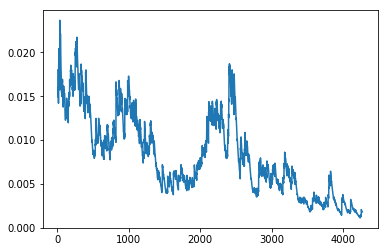

In [335]:
learn.save(f'{sz}')
learn.sched.plot_loss()

In [336]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.002046   0.020005   0.996011  



[0.020004524, 0.9960106382978723]

In [337]:
learn.save(f'{sz}_v2')

In [422]:
learn.load(f'{sz}_v2')

### Assessing model

Let's access the val set performance first.

In [423]:
log_preds, y = learn.TTA()

In [424]:
probs = np.mean(np.exp(log_preds), axis=0)

In [425]:
def accuracy_np(preds, targs):
    preds = np.argmax(preds, 1)
    return (preds==targs).mean()

In [426]:
accuracy_np(probs, y)

0.996

In [427]:
preds = np.argmax(probs, 1)

In [428]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, preds)

[[282   0   0   0   0   0   1   0   0   0]
 [  0 343   0   0   0   0   0   2   0   0]
 [  0   0 292   0   0   0   0   1   0   0]
 [  0   0   0 300   0   0   0   0   0   0]
 [  0   0   0   0 292   0   0   0   0   2]
 [  0   1   0   0   0 262   0   0   0   0]
 [  1   0   0   0   1   0 271   0   0   0]
 [  0   0   0   0   0   0   0 324   0   0]
 [  0   0   2   0   0   0   0   0 289   0]
 [  0   0   0   0   1   0   0   0   0 333]]


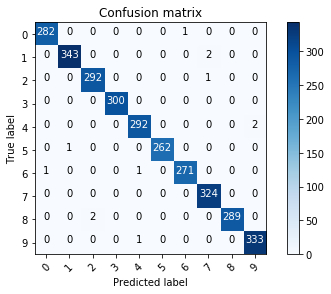

In [429]:
plot_confusion_matrix(cm, np.arange(0, 10))

Doesn't appear to be anything single number that we're consistently getting wrong.

Let's take a look at all the bad predictions:

In [430]:
idxs = np.where((preds != y))[0]

In [431]:
imgs = []
titles = []

for idx in idxs:
    imgs.append(data.val_ds[idx][0].transpose(1, 2, 0))
    titles.append(f'Actual: {data.val_y[idx]}, Pred: {preds[idx]}')

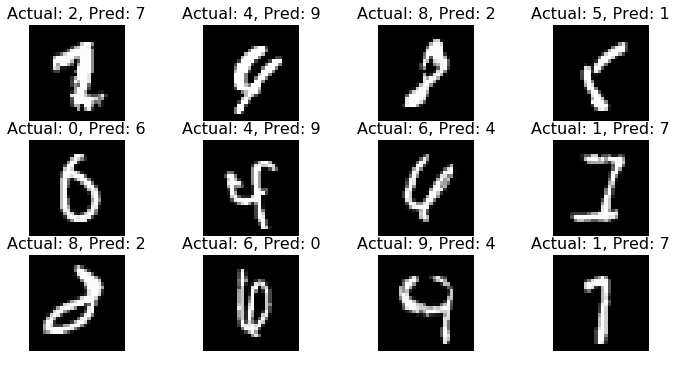

In [432]:
plots(imgs, titles=titles, rows=3)

* Thinking data augmentations could help here, if I can figure them out.

## Preparing the test data

In [444]:
test_n = len(list(open('./data/mnist-kaggle/test.csv'))) - 1

In [447]:
test_imgs = np.zeros((test_n, 28, 28), dtype=np.float32)

In [448]:
fh = open('./data/mnist-kaggle/test.csv')
csv_reader = csv.reader(fh)
header = next(csv_reader)

for i, line in enumerate(csv_reader):
    test_imgs[i] = load_img(line)

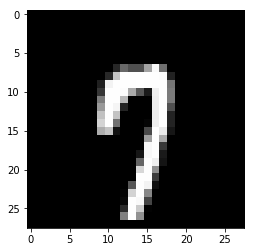

In [449]:
plt.imshow(test_imgs[1001], cmap='gray')

In [450]:
test_imgs = np.stack((test_imgs,) * 3, axis=-1) / 255
test_imgs = test_imgs.transpose((0, 3, 1, 2))

In [451]:
test_imgs.shape

(28000, 3, 28, 28)

## Predict test data

In [452]:
data = ImageClassifierData.from_arrays(
    './data/mnist-kaggle/',
    trn=(training_set, training_labels.astype(np.int8)),
    val=(val_set, val_labels.astype(np.int8)), test=test_imgs)

In [453]:
learn.set_data(data)

In [457]:
predictions = learn.predict(is_test=True)

In [466]:
preds = np.argmax(predictions, axis=1)

In [467]:
type(predictions)

numpy.ndarray

In [469]:
preds.shape

(28000,)

Take a look at a couple of predictions:

In [476]:
test_imgs = []
test_titles = []

for i in range(100):
    test_imgs.append(data.test_ds[i][0].transpose(1, 2, 0))
    test_titles.append(preds[i])

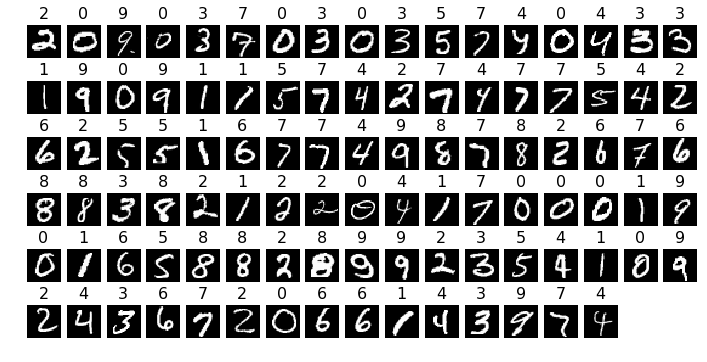

In [478]:
plots(test_imgs, titles=test_titles, rows=6)

Looks pretty damn good! Let's submit this baby.

## Submit to Kaggle

In [479]:
!head data/mnist-kaggle/sample_submission.csv

In [497]:
test_ids = []
test_preds = []

for i in range(len(preds)):
    test_ids.append(i + 1)
    test_preds.append(preds[i])

In [498]:
df = pd.DataFrame(data={'ImageId': test_ids, 'Label': test_preds})

In [499]:
df.to_csv('./data/mnist-kaggle/submission.csv.gz', index=False, compression='gzip')

In [501]:
!zcat ./data/mnist-kaggle/submission.csv.gz | tail

27991,7
27992,6
27993,1
27994,9
27995,7
27996,9
27997,7
27998,3
27999,9
28000,2


In [502]:
from IPython.display import FileLink
FileLink('./data/mnist-kaggle/submission.csv.gz')

/home/lex/study-notes/moocs/fast.ai/deep-learning-2018/data/mnist-kaggle/submission.csv.gz

* Puts me at 233:

<img src="./images/mnist-kaggle-position.png">